In [3]:
import pandas as pd
import numpy as np
from spacy.en import English
nlp = English()
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
import matplotlib.pyplot as plt
%matplotlib inline

import psycopg2 as pg2
import psycopg2.extras as pgex
this_host='34.211.59.66'
this_user='postgres'
this_password='postgres'
conn = pg2.connect(host = this_host, 
                        user = this_user,
                        password = this_password)

sql_select = '''select created_at, location, tweet_content, cleaned_tweet, vector from tweets;'''

cur = conn.cursor(cursor_factory=pgex.RealDictCursor)
cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)

In [34]:
def tweets_event_ab_test(event, n = 200):
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    event_tweet.reset_index(inplace = True)
    
    A_index = list(range(event_tweet.shape[0]))
    random.shuffle(A_index)
    
    n = n
    A1_index = []
    for i in range(n):
        A1_index.append(A_index.pop())
    
    A1 = event_tweet.iloc[A1_index,:]
    A1.reset_index(inplace = True)
    A1_vec = np.array([nlp(i).vector for i in A1['cleaned_tweet']])
    
    A2 = event_tweet.iloc[A_index,:] 
    A2.reset_index(inplace = True)
    A2_vec = np.array([nlp(i).vector for i in A2['cleaned_tweet']])
    non_event_tweet = df[~df['cleaned_tweet'].str.contains(('event'))]
    non_event_tweet.reset_index(inplace = True)
    
    B_index = list(range(non_event_tweet.shape[0]))
    random.shuffle(B_index)
    n = n
    B1_index = []
    for i in range(n):
        B1_index.append(B_index.pop())
    m = A2.shape[0]
    B2_index = []
    for i in range(m):
        B2_index.append(B_index.pop())  
    
    
    B1 = non_event_tweet.iloc[B1_index,:]
    B1.reset_index(inplace = True)
    B1_vec = np.array([nlp(i).vector for i in B1['cleaned_tweet']])
    
    B2 = non_event_tweet.iloc[B2_index,:]
    B2.reset_index(inplace = True)
    B2_vec = np.array([nlp(i).vector for i in B2['cleaned_tweet']])
    
    A1_vec_mean = np.average(A1_vec, axis=0)
    A2_vec_mean = np.average(A2_vec, axis=0)
    B1_vec_mean = np.average(B1_vec, axis=0)
    B2_vec_mean = np.average(B2_vec, axis=0)
    
    a1a2 = cosine_similarity(A1_vec_mean.reshape(1,-1),A2_vec_mean.reshape(1,-1))[0][0]
    b1b2 = cosine_similarity(B2_vec_mean.reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0]
    a1b1 = cosine_similarity(A1_vec_mean.reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0]
    a2b2 = cosine_similarity(A2_vec_mean.reshape(1,-1),B2_vec_mean.reshape(1,-1))[0][0]
   
    a2_consim_list = []
    for i in range(min(n,m)):  
        a2_consim_list.append(cosine_similarity(A2_vec[i].reshape(1,-1),A1_vec_mean.reshape(1,-1))[0][0])
    a2_mean = np.mean(np.array(a2_consim_list))
    a2_std = np.std(np.array(a2_consim_list))
    
    b2_consim_list = []
    for i in range(min(n,m)):  
        b2_consim_list.append(cosine_similarity(B2_vec[i].reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0])
    b2_mean = np.mean(b2_consim_list)
    b2_std = np.std(b2_consim_list)
    
    a1b2_consim_list = []
    for i in range(min(n,m)):  
        a1b2_consim_list.append((cosine_similarity(B2_vec[i].reshape(1,-1),A1_vec_mean.reshape(1,-1))[0][0]))
    a1b2_mean = np.mean(a1b2_consim_list)
    a1b2_std = np.std(a1b2_consim_list)
    
    print('A1|A2: ',a1a2,'\n'
                'B1|B2: ',b1b2, '\n\n'
                'A1|B1: ',a1b1, '\n'
                'A2|B2: ', a2b2, '\n\n'
                'Cosine Similarity Mean of A2 to A1', a2_mean, '\n'
                'Cosine Similarity Mean of B2 to B1', b2_mean, '\n'
                'Cosine Similarity Mean of B2 to A1', a1b2_mean, '\n\n'
                'Cosine Similarity STD of A2 to A1', a2_std, '\n'
                'Cosine Similarity STD of B2 to B1', b2_std, '\n'
                'Cosine Similarity STD of B2 to A1', a1b2_std, '\n'                 
                )
    
    return a2_consim_list, b2_consim_list

In [35]:
a2_consim_list, b2_consim_list = tweets_event_ab_test('paris|climate')

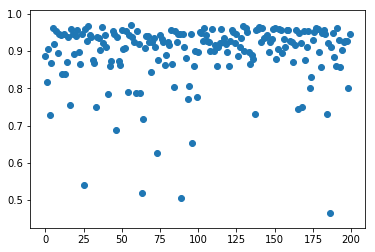

In [36]:
plt.scatter(range(len(a2_consim_list)), a2_consim_list)

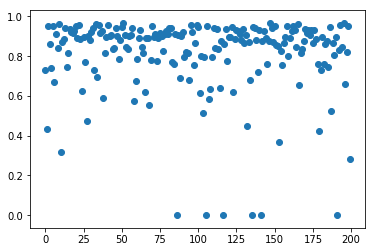

In [37]:
plt.scatter(range(len(b2_consim_list)), b2_consim_list)

In [21]:
def event_tweet_count(event):
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    return len(event_tweet)

In [68]:
event_tweet_count('nbafinal')

884

In [99]:
tweets_event_ab_test('nbafinal', n = 200)

A1|A2:  0.999517 
B1|B2:  0.998863 

A1|B1:  0.942272 
A2|B2:  0.941313 

Cosine Similarity Mean of A2 to A1 0.87911 
Cosine Similarity Mean of B2 to B1 0.83723 
Cosine Similarity Mean of B2 to A1 0.788635 

Cosine Similarity STD of A2 to A1 0.0672957 
Cosine Similarity STD of B2 to B1 0.16936 
Cosine Similarity STD of B2 to A1 0.1539 



In [98]:
tweets_event_ab_test('travel ban', n = 100)

A1|A2:  0.998085 
B1|B2:  0.996229 

A1|B1:  0.953957 
A2|B2:  0.956234 

Cosine Similarity Mean of A2 to A1 0.924944 
Cosine Similarity Mean of B2 to B1 0.86136 
Cosine Similarity Mean of B2 to A1 0.826672 

Cosine Similarity STD of A2 to A1 0.0345357 
Cosine Similarity STD of B2 to B1 0.0838027 
Cosine Similarity STD of B2 to A1 0.0857711 



In [25]:
def Top_tweets_in_b(event, n = 200):
    A = df[df['cleaned_tweet'].str.contains((event))]
    A.reset_index(inplace = True)
    A_vec = np.array([nlp(i).vector for i in A['cleaned_tweet']])
    A_vec_mean = np.average(A_vec, axis=0)
    
    
    B = df[~df['cleaned_tweet'].str.contains(('event'))]
    B.reset_index(inplace = True)
    
    B_index = list(range(B.shape[0]))
    random.shuffle(B_index)
    n = n
    B1_index = []
    for i in range(n):
        B1_index.append(B_index.pop())
   
        
    B1 = B.iloc[B1_index,:]
    B1.reset_index(inplace = True)
    B1_vec = np.array([nlp(i).vector for i in B1['cleaned_tweet']])
    
    
    consim_twt_list = []
    for i in range(n):  
        consim_twt_list.append((cosine_similarity(B1_vec[i].reshape(1,-1),A_vec_mean.reshape(1,-1))[0][0], B1['cleaned_tweet'][i]))
    pd.options.display.max_colwidth = 200
    result = pd.DataFrame(consim_twt_list, columns = ['score','tweet'])
    print(result.shape)
    result_90 = result[result['score']>.90]
    result_90.sort_values('score', axis = 0, ascending = False)
    return result_90['tweet'].values

In [26]:
Top_tweets_in_b('paris|climate', n = 30000)

(30000, 2)


array([ 'sorry, but i mostly disagree with here. good pt about being authentic, but brands need agencies that know ho… ',
       'so…… the 25 cent butt fuck club is going to need to order more towels.',
       'linguistics friends: is anyone good at tweaking textgrids to silence values?',
       ...,
       ' not bragging but yeah i do know how beautician and the beats ends.',
       'lebron look like he already gave up.',
       'this is literally what he was waiting for thats why he smiled i love my sneaky man '], dtype=object)

In [22]:
event_tweet_count('nationaldonutday')

527

In [18]:
Top_tweets_in_b('nationaldonutday')

array([ 'i think and must be thinking about improvements like this. #walkla #bikela #terrorism ',
       'la is attacking which is great but we need a goal! #lagalaxy #dcvla',
       'want to work in #losangeles, ca? view our latest opening: #autism #mentalhealth #education #job #jobs #hiring',
       "hey twitter world who thing's megyn kelly is a cool person on twitter yo #twitterworld #neff #godblessamerica  ",
       'can you recommend anyone for this #job in #westcovina, ca? #healthwelfare #hiring',
       "if you're looking for work in #elsegundo, ca, check out this #job: #engineering #hiring",
       'san diego, #ff follow we do free drone giveaway every #funcationfriday &gt; ',
       '#globtv #repost the_slabbajak ・・・ boro_shinobi hit me with a #stopdropandglob so ima pass it… '], dtype=object)

In [23]:
tweets_event_ab_test('nationaldonutday', n = 200)

A1|A2:  0.998847 
B1|B2:  0.998194 

A1|B1:  0.924215 
A2|B2:  0.918105 

Cosine Similarity Mean of A2 to A1 0.874205 
Cosine Similarity Mean of B2 to B1 0.831707 
Cosine Similarity Mean of B2 to A1 0.760502 

Cosine Similarity STD of A2 to A1 0.0606509 
Cosine Similarity STD of B2 to B1 0.179938 
Cosine Similarity STD of B2 to A1 0.162105 

